In [1]:
# hsq_occupied_seasonality_analysis (streamlined)
from pathlib import Path
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

sns.set_theme(style="whitegrid", palette="Set2")

DATA_PATH = Path("../data/hsq_df.csv")
raw_slots = pd.read_csv(DATA_PATH)

In [2]:
# 1) Focus on occupied slots only
occupied_codes = {"O", "H", "R"}
occupied_slots = raw_slots[raw_slots["bookingStatus"].isin(occupied_codes)].copy()
occupied_slots["bookingStatus"] = occupied_slots["bookingStatus"].replace({"O": "Z", "H": "Z", "R": "Z"})
occupied_slots["bookingDate"] = pd.to_datetime(occupied_slots["bookingDate"], utc=True, errors="coerce")
occupied_slots = occupied_slots.dropna(subset=["bookingDate"])

In [3]:
# 2) Build continuous daily occupied counts
daily_occupied = (
    occupied_slots.assign(Date=lambda df: df["bookingDate"].dt.normalize())
    .groupby("Date")
    .size()
    .reset_index(name="occupied_count")
    .sort_values("Date")
)

full_range = pd.date_range(daily_occupied["Date"].min(), daily_occupied["Date"].max(), freq="D")
daily_occupied = daily_occupied.set_index("Date").reindex(full_range)
daily_occupied["occupied_count"] = daily_occupied["occupied_count"].ffill()
daily_occupied = daily_occupied.rename_axis("Date").reset_index()
daily_occupied["Date"] = pd.to_datetime(daily_occupied["Date"]).dt.tz_localize(None)

In [4]:
# 3) Derive helper columns for seasonality views
seasonality_df = daily_occupied.copy()
seasonality_df["month"] = seasonality_df["Date"].dt.month
seasonality_df["weekday"] = seasonality_df["Date"].dt.weekday
weekday_order = list(range(7))
do = seasonality_df[["Date", "occupied_count"]].copy()

/var/folders/fq/3pmzyx3s60l0sjm0lfcpdfhh0000gn/T/ipykernel_48444/1275685714.py:7: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.violinplot(
/var/folders/fq/3pmzyx3s60l0sjm0lfcpdfhh0000gn/T/ipykernel_48444/1275685714.py:7: FutureWarning: 

The `scale` parameter has been renamed and will be removed in v0.15.0. Pass `density_norm='width'` for the same effect.
  sns.violinplot(
/var/folders/fq/3pmzyx3s60l0sjm0lfcpdfhh0000gn/T/ipykernel_48444/1275685714.py:44: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.violinplot(
/var/folders/fq/3pmzyx3s60l0sjm0lfcpdfhh0000gn/T/ipykernel_48444/1275685714.py:44: FutureWarning: 

The `scale` parameter has been renamed and will be removed in v0.15.0. Pass `density_norm='width

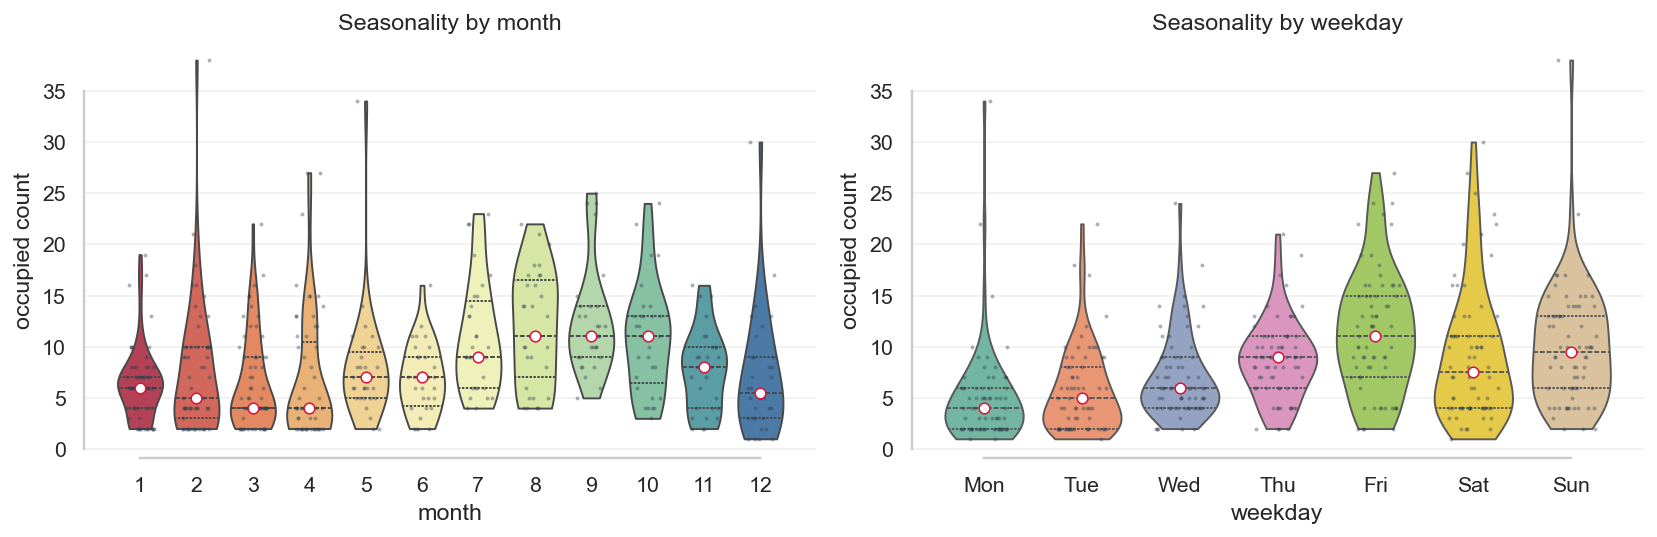

In [5]:
# 4) Seasonality violin plots (month & weekday)
month_median = seasonality_df.groupby("month")["occupied_count"].median().reindex(range(1, 13))
weekday_median = seasonality_df.groupby("weekday")["occupied_count"].median().reindex(weekday_order)

fig, axes = plt.subplots(1, 2, figsize=(12, 4), dpi=140)

sns.violinplot(
    data=seasonality_df,
    x="month",
    y="occupied_count",
    order=list(range(1, 13)),
    palette=sns.color_palette("Spectral", 12),
    inner="quartile",
    cut=0,
    scale="width",
    linewidth=1.0,
    ax=axes[0],
)
sns.stripplot(
    data=seasonality_df,
    x="month",
    y="occupied_count",
    order=list(range(1, 13)),
    color="#2c3e50",
    size=2.0,
    alpha=0.4,
    jitter=0.25,
    ax=axes[0],
)
axes[0].scatter(
    range(12),
    month_median.values,
    s=30,
    zorder=4,
    facecolor="white",
    edgecolor="crimson",
    linewidth=0.8
)
axes[0].set_title("Seasonality by month")
axes[0].set_xlabel("month")
axes[0].set_ylabel("occupied count")
axes[0].grid(axis="y", alpha=0.25)

sns.violinplot(
    data=seasonality_df,
    x="weekday",
    y="occupied_count",
    order=weekday_order,
    palette=sns.color_palette("Set2", 7),
    inner="quartile",
    cut=0,
    scale="width",
    linewidth=1.0,
    ax=axes[1],
)
sns.stripplot(
    data=seasonality_df,
    x="weekday",
    y="occupied_count",
    order=weekday_order,
    color="#2c3e50",
    size=2.0,
    alpha=0.4,
    jitter=0.25,
    ax=axes[1],
)
axes[1].scatter(
    range(7),
    weekday_median.values,
    s=30,
    zorder=4,
    facecolor="white",
    edgecolor="crimson",
    linewidth=0.8
)
axes[1].set_title("Seasonality by weekday")
axes[1].set_xlabel("weekday")
axes[1].set_ylabel("occupied count")
axes[1].set_xticks(weekday_order)
axes[1].set_xticklabels(["Mon", "Tue", "Wed", "Thu", "Fri", "Sat", "Sun"])
axes[1].grid(axis="y", alpha=0.25)

sns.despine(trim=True)
plt.tight_layout()
plt.show()

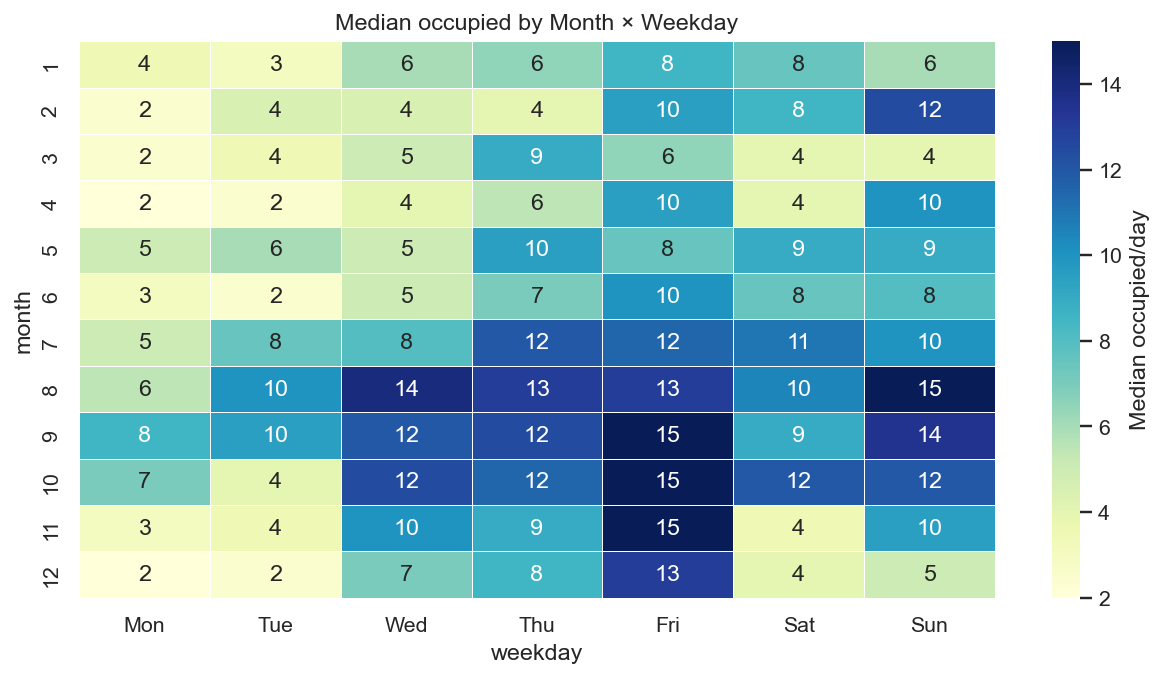

In [6]:
# 5) Month × Weekday heatmap (median occupied count)
heatmap = (
    seasonality_df.groupby(["month", "weekday"], as_index=False)["occupied_count"]
    .median()
    .pivot(index="month", columns="weekday", values="occupied_count")
    .reindex(index=list(range(1, 13)), columns=weekday_order)
)

fig, ax = plt.subplots(figsize=(9, 5), dpi=140)
sns.heatmap(
    heatmap,
    ax=ax,
    cmap="YlGnBu",
    annot=True,
    fmt=".0f",
    linewidths=0.4,
    linecolor="white",
    cbar_kws={"label": "Median occupied/day"}
)
ax.set_title("Median occupied by Month × Weekday")
ax.set_xlabel("weekday")
ax.set_ylabel("month")
ax.set_xticklabels(["Mon", "Tue", "Wed", "Thu", "Fri", "Sat", "Sun"], rotation=0)
plt.tight_layout()
plt.show()

/var/folders/fq/3pmzyx3s60l0sjm0lfcpdfhh0000gn/T/ipykernel_48444/3419851474.py:58: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.violinplot(
/var/folders/fq/3pmzyx3s60l0sjm0lfcpdfhh0000gn/T/ipykernel_48444/3419851474.py:58: FutureWarning: 

The `scale` parameter has been renamed and will be removed in v0.15.0. Pass `density_norm='width'` for the same effect.
  sns.violinplot(
/var/folders/fq/3pmzyx3s60l0sjm0lfcpdfhh0000gn/T/ipykernel_48444/3419851474.py:93: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels([f"{cat}\n(n={counts.get(cat, 0)})" for cat in plot_cats])


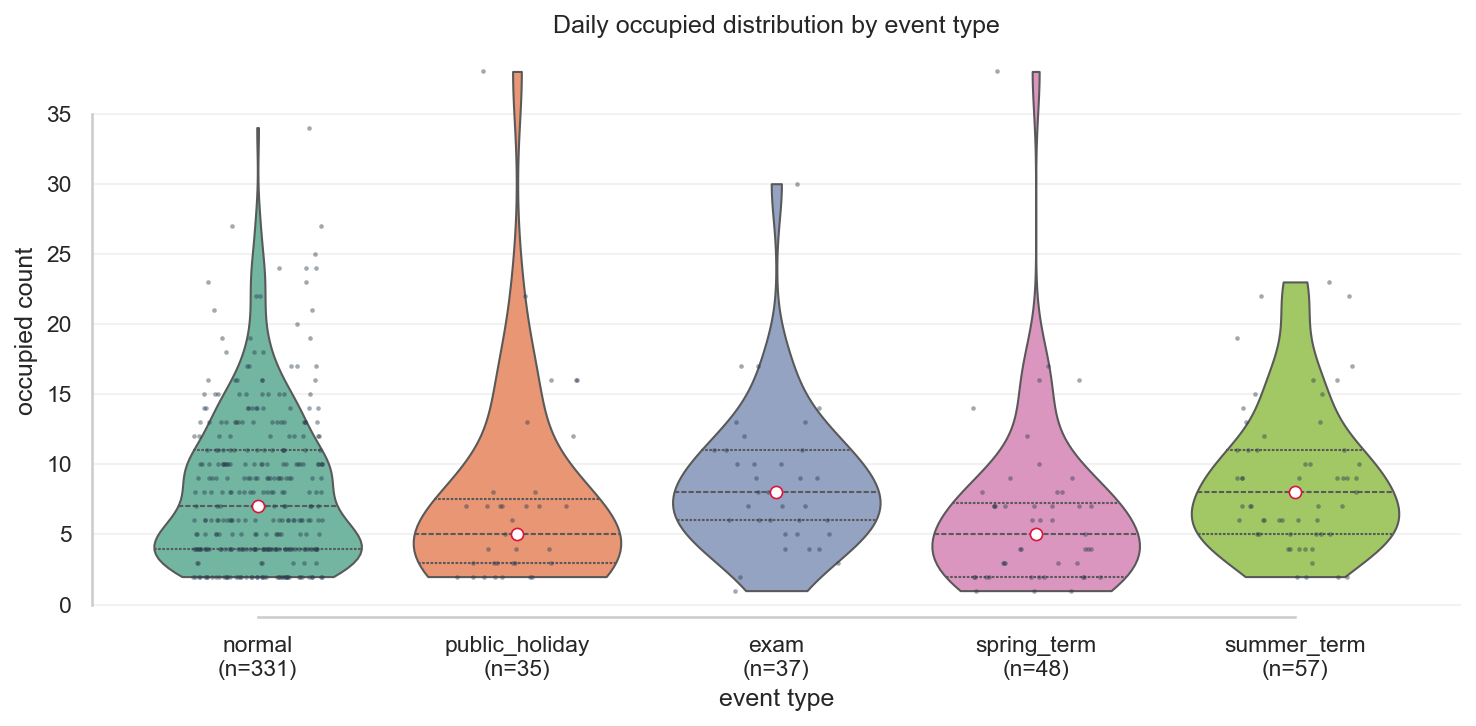

In [7]:
# 6) Event-type violin (calendar overlay only)
calendar_raw = pd.concat([
    pd.read_csv("../data/um_academic_calendar_2022_23.csv"),
    pd.read_csv("../data/um_academic_calendar_2023_24.csv"),
], ignore_index=True)

calendar = (
    calendar_raw.copy()
    .rename(columns={
        "tart_date": "start_date",
        "start date": "start_date",
        "end date": "end_date",
        "events": "event",
    })
)
calendar["start_date"] = pd.to_datetime(calendar["start_date"], errors="coerce")
calendar["end_date"] = pd.to_datetime(calendar["end_date"], errors="coerce")
calendar.loc[calendar["end_date"].isna(), "end_date"] = calendar.loc[calendar["end_date"].isna(), "start_date"]
calendar = calendar.dropna(subset=["start_date", "end_date"]).reset_index(drop=True)

focus_set = {"public_holiday", "exam", "spring_term", "summer_term"}
holiday_kw = ["festival", "day", "national day", "holiday"]
exam_kw = ["exam", "examination", "contingency", "final exam"]

def infer_type(row: pd.Series) -> str:
    t = str(row.get("type", "")).strip().lower()
    e = str(row.get("event", "")).strip().lower()
    if t in focus_set:
        return t
    if any(k in e for k in exam_kw):
        return "exam"
    if any(k in e for k in holiday_kw):
        return "public_holiday"
    if "spring" in e and "term" in e:
        return "spring_term"
    if "summer" in e and "term" in e:
        return "summer_term"
    return "other"

calendar["event_type"] = calendar.apply(infer_type, axis=1)
calendar_days = (
    calendar.assign(Date=calendar.apply(lambda r: pd.date_range(r["start_date"], r["end_date"], freq="D"), axis=1))
    .explode("Date")
    .assign(Date=lambda df: df["Date"].dt.normalize())
)

impact_df = (
    daily_occupied.merge(calendar_days[["Date", "event_type"]], on="Date", how="left")
    .assign(event_type=lambda df: df["event_type"].where(df["event_type"].isin(focus_set), "normal"))
)

plot_cats = ["normal", "public_holiday", "exam", "spring_term", "summer_term"]
plot_df = impact_df[impact_df["event_type"].isin(plot_cats)].copy()
counts = plot_df["event_type"].value_counts().reindex(plot_cats).fillna(0).astype(int)
medians = plot_df.groupby("event_type")["occupied_count"].median().reindex(plot_cats)

fig, ax = plt.subplots(figsize=(10, 5), dpi=150)
sns.violinplot(
    data=plot_df,
    x="event_type",
    y="occupied_count",
    order=plot_cats,
    palette=sns.color_palette("Set2", len(plot_cats)),
    cut=0,
    inner="quartile",
    scale="width",
    linewidth=1.0,
    ax=ax,
)
sns.stripplot(
    data=plot_df,
    x="event_type",
    y="occupied_count",
    order=plot_cats,
    color="#2c3e50",
    size=2.2,
    alpha=0.45,
    jitter=0.25,
    ax=ax,
)
ax.scatter(
    range(len(plot_cats)),
    medians.values,
    s=34,
    facecolor="white",
    edgecolor="crimson",
    linewidth=0.8,
    zorder=4,
)
ax.set_title("Daily occupied distribution by event type")
ax.set_xlabel("event type")
ax.set_ylabel("occupied count")
ax.set_xticklabels([f"{cat}\n(n={counts.get(cat, 0)})" for cat in plot_cats])
ax.grid(axis="y", alpha=0.25)
sns.despine(trim=True)
plt.tight_layout()
plt.show()